# 🔎 Grocery Pricing Visualization

## Overview
This notebook explores the dataset that was assembled during the Data Processing phase of this project. The goal will not be a comprehensive analysis or modeling, but will examine summary statistics, perform basic cleaning tasks and begin to examine correlation between variables. 

## Goals
- **Visualize grocery pricing by ZIP code** using geospatial maps.
- **Analyze price distributions** across product categories.
- **Identify correlations** between food pricing and socioeconomic factors.
- **Explore keyword trends** in grocery product descriptions.

## Data Preparation

Before visualizing the data, we **load the processed dataset** and ensure:
- Geospatial boundaries (`geometry`) are set correctly.
- Product descriptions are preprocessed for keyword analysis.
- Price and census fields are formatted for statistical analysis.

In [ ]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import geopandas as gpd
from shapely import wkt
import contextily as ctx 
import ast

BASE_DIR = os.path.abspath(os.path.dirname(os.getcwd()))

# Define directories relative to `BASE_DIR`
SRC_DIR = os.path.join(BASE_DIR, "src")  # Points to `src/`
DATA_DIR = os.path.join(SRC_DIR, "data")  # Points to `src/data/`
NOTEBOOKS_DIR = os.path.join(BASE_DIR, "notebooks")  # Points to `notebooks/`

# Define file paths
SHAPEFILE = os.path.join(DATA_DIR, "2020_ZCTA/tl_2020_us_zcta520.shp")
NATURALE_EARTH = os.path.join(DATA_DIR, "Natural_Earth/ne_110m_admin_1_states_provinces.shp")
FINAL_DATASET_PATH = os.path.join(DATA_DIR, "final_dataset.csv")

print(f"Base Directory: {BASE_DIR}")
print(f"Data Directory: {DATA_DIR}")
print(f"Notebooks Directory: {NOTEBOOKS_DIR}")
print(f"Final Dataset Path: {FINAL_DATASET_PATH}")

# Define certain data types for read
dtype_dict = {
    "ZIP Code": str,
    "ZCTA5CE20": str,                           
    "GEOID20": str 
}

# Load files into dataframes
df = pd.read_csv(FINAL_DATASET_PATH, dtype=dtype_dict)

# Convert WKT strings into valid geometries
df["geometry"] = df["geometry"].apply(wkt.loads)

# Convert DataFrame to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4269")

# Convert dictionary only if the value is a string
df["ZIP_Keyword_Frequency"] = df["ZIP_Keyword_Frequency"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Verify dictionary type
print(df["ZIP_Keyword_Frequency"].apply(type).value_counts())

print(df.dtypes)  # Make sure `geometry` is now a 'geometry' dtype
print(df.head())  # Check a few rows

Base Directory: c:\Users\iauge\Documents\Drexel MSDS\DSCI 511\Project Files\01-project\grocery-pricing-study\kroger-data-pipeline
Data Directory: c:\Users\iauge\Documents\Drexel MSDS\DSCI 511\Project Files\01-project\grocery-pricing-study\kroger-data-pipeline\src\data
Notebooks Directory: c:\Users\iauge\Documents\Drexel MSDS\DSCI 511\Project Files\01-project\grocery-pricing-study\kroger-data-pipeline\notebooks
Final Dataset Path: c:\Users\iauge\Documents\Drexel MSDS\DSCI 511\Project Files\01-project\grocery-pricing-study\kroger-data-pipeline\src\data\final_dataset.csv
ZIP_Keyword_Frequency
<class 'dict'>    1151
Name: count, dtype: int64
ZIP Code                            object
Store_Count                          int64
Store_Chain_Distribution            object
Avg_Latitude                       float64
Avg_Longitude                      float64
Total Population                   float64
Median Household Income            float64
Poverty Rate (%)                   float64
SNAP Parti

## Price Distribution Analysis

This section computes **summary statistics** for product pricing:
- **Average, minimum, and maximum prices** per product category.
- **Median price trends** across different grocery items.
- **Standard deviation of prices** to assess variability.


In [53]:
# Summary statistics by product category
summary_fields = ["Avg_Price", "Min_Price", "Max_Price", "Median_Price"]
for i in summary_fields:
    print("Section: " + i)
    display(df.groupby("Product Category")[i].describe())


Section: Avg_Price


,count,mean,std,min,25%,50%,75%,max
Product Category,,,,,,,,
Bread,631.0,0.242078,0.325793,0.0,0.168626,0.191812,0.223445,2.803225
Egg,520.0,0.386153,0.346291,0.0,0.283122,0.337617,0.437545,5.014056


Section: Min_Price


,count,mean,std,min,25%,50%,75%,max
Product Category,,,,,,,,
Bread,631.0,0.132666,0.059556,0.0,0.103750,0.103750,0.145417,0.290833
Egg,520.0,0.197233,0.088536,0.0,0.138167,0.202813,0.224167,0.665833


Section: Max_Price


,count,mean,std,min,25%,50%,75%,max
Product Category,,,,,,,,
Bread,631.0,0.389841,0.690129,0.0,0.2395,0.290833,0.293889,5.29
Egg,520.0,0.653052,0.744394,0.0,0.4825,0.581667,0.665833,9.58


Section: Median_Price


,count,mean,std,min,25%,50%,75%,max
Product Category,,,,,,,,
Bread,631.0,0.242769,0.322081,0.0,0.168954,0.203750,0.224500,2.759945
Egg,520.0,0.374993,0.344713,0.0,0.284028,0.332778,0.422051,5.011944


## Pricing Distribution Review

The above ranges showed significant outliers populate the dataset, far outside the 75-percentile range. For this reason,  we will  re-run our summary reporting while leveraging the IQR method to  help normalize the data and reduce the influence of outliers. 

In [54]:
# Summary statistics by product category with IQR filtering
summary_fields = ["Avg_Price", "Min_Price", "Max_Price", "Median_Price"]

for field in summary_fields:
    category_stats = []
    
    # Apply IQR filtering per product category
    for category in df["Product Category"].unique():
        category_data = df[df["Product Category"] == category][field].dropna()
        
        # Compute IQR
        Q1 = category_data.quantile(0.25)
        Q3 = category_data.quantile(0.75)
        IQR = Q3 - Q1
        
        # Filter out outliers
        filtered_data = category_data[(category_data >= (Q1 - 1.5 * IQR)) & (category_data <= (Q3 + 1.5 * IQR))]
        
        category_stats.append(filtered_data.describe())  # Store stats per category
    
    print(f"Section: {field} (IQR-Filtered)")
    display(pd.DataFrame(category_stats, index=df["Product Category"].unique()))


Section: Avg_Price (IQR-Filtered)


,count,mean,std,min,25%,50%,75%,max
Bread,602.0,0.196990,0.036030,0.0995,0.168679,0.191812,0.221167,0.290833
Egg,502.0,0.354403,0.101976,0.0775,0.283956,0.336949,0.429861,0.665833


Section: Min_Price (IQR-Filtered)


,count,mean,std,min,25%,50%,75%,max
Bread,509.0,0.113012,0.028046,0.0495,0.103750,0.103750,0.132917,0.1995
Egg,474.0,0.188252,0.056387,0.0525,0.138167,0.202813,0.224167,0.3325


Section: Max_Price (IQR-Filtered)


,count,mean,std,min,25%,50%,75%,max
Bread,474.0,0.260327,0.034334,0.1645,0.239500,0.239500,0.290833,0.368750
Egg,471.0,0.552564,0.157295,0.2075,0.490833,0.581667,0.665833,0.881667


Section: Median_Price (IQR-Filtered)


,count,mean,std,min,25%,50%,75%,max
Bread,604.0,0.198914,0.037703,0.0995,0.169344,0.199500,0.224500,0.304861
Egg,500.0,0.341904,0.099343,0.0775,0.284028,0.332639,0.422051,0.582500


## Mapping Grocery Pricing by ZIP Code

This section visualizes **price trends by ZIP code** using geospatial maps.
- **ZIP Code Boundaries** are used to color-code price variations.
- **State Boundaries** provide geographic context.
- **A basemap overlay** is added for reference.

The map allows us to identify **regional price disparities** in food access.

The current map provides a broad view of grocery pricing but could be improved for deeper insights. 
My own limitations and inexperience working with geospatial data are also  pretty evident here.
Future updates to the dataset and methodology may yield more actionable findings.

### Future Mapping Improvements
- **Retaining State variable for ZIP Codes** will allow application of state specific maps.
- **Expanded Product Dataset** will offer a better understanding of the pricing range.
- **Incorporation of missing locations** will present a fully national  network of stores.


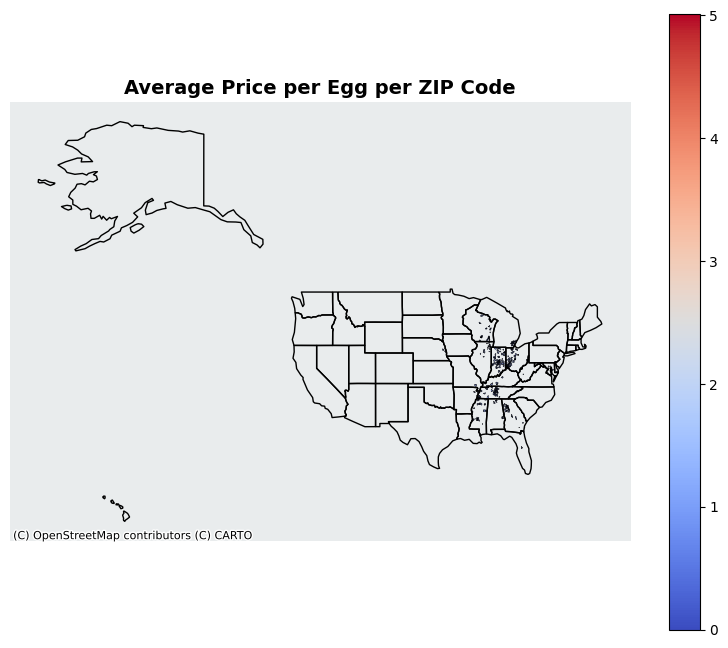

In [47]:

# Ensure 'geometry' is correctly assigned as active geometry
df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4269")  # Ensure CRS is set

# Filter for ZIP codes where the Product Category is "Egg"
egg_df = df[df["Product Category"].str.lower() == "egg"]  # Case-insensitive match

# Load the state boundaries shapefile
states = gpd.read_file(NATURALE_EARTH)

# Set up figure size & projection
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot ZIP Code boundaries with average price
egg_df.plot(column="Avg_Price", cmap="coolwarm", linewidth=0.3, edgecolor="black", legend=True, alpha=0.7, ax=ax)

# Overlay State Boundaries
states.boundary.plot(ax=ax, color="black", linewidth=1)

# Add Basemap for Context
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=5, alpha=0.5)

# Titles & Labels
ax.set_title("Average Price per Egg per ZIP Code", fontsize=14, fontweight="bold")
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.show()


## Price Distribution Analysis

This section visualizes **price distributions** across product categories using histograms. By applying **IQR filtering**, we remove outliers to focus on meaningful trends.

#### Key Insights
- **Price variability** differs by category, with some showing wider ranges.
- **Right-skewed distributions** indicate most prices are low with a few high-cost outliers.
- **Bimodal patterns** suggest distinct pricing tiers (e.g., organic vs. non-organic).
- **Density overlays** highlight concentration points in price distributions.

Histograms help reveal **pricing trends and anomalies**, supporting deeper analysis.


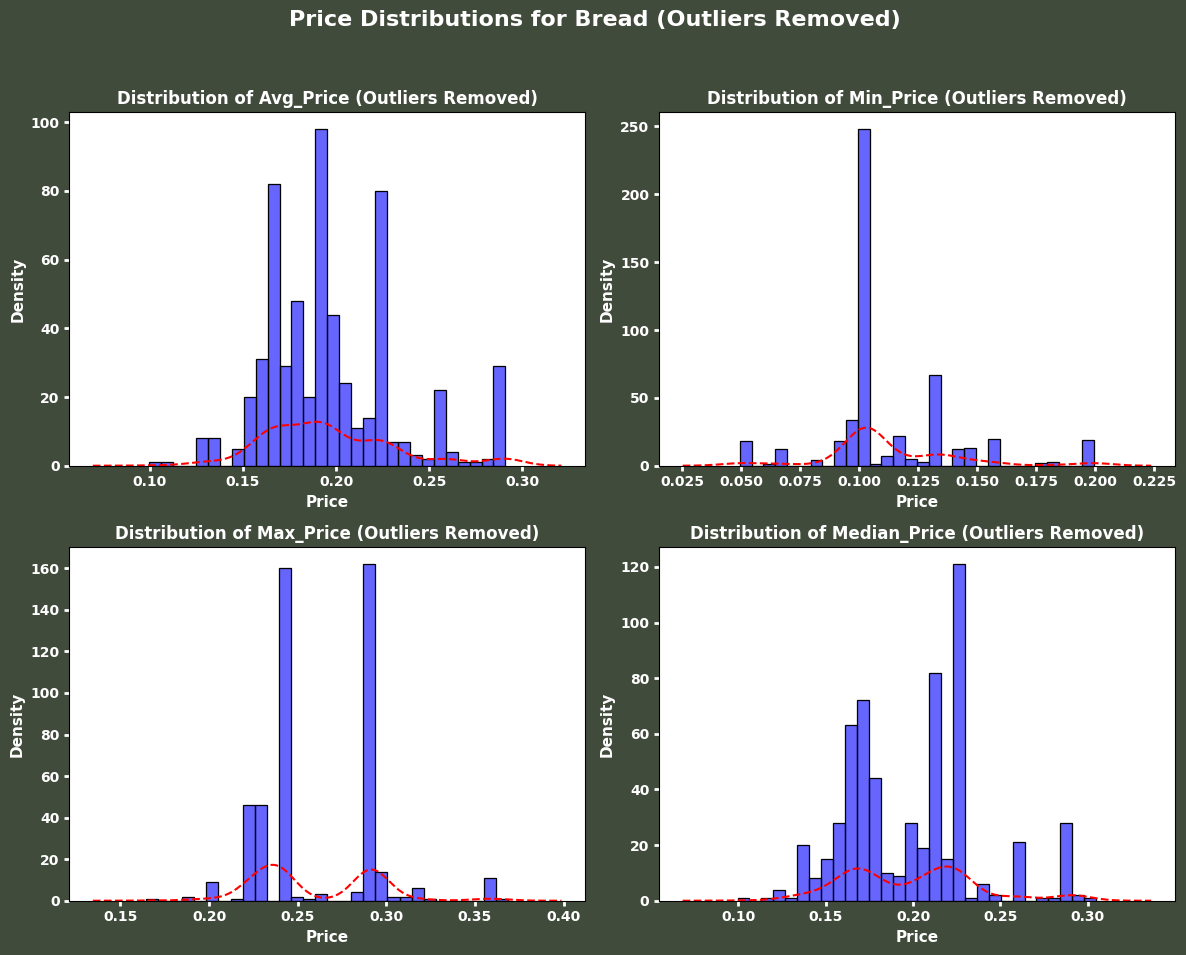

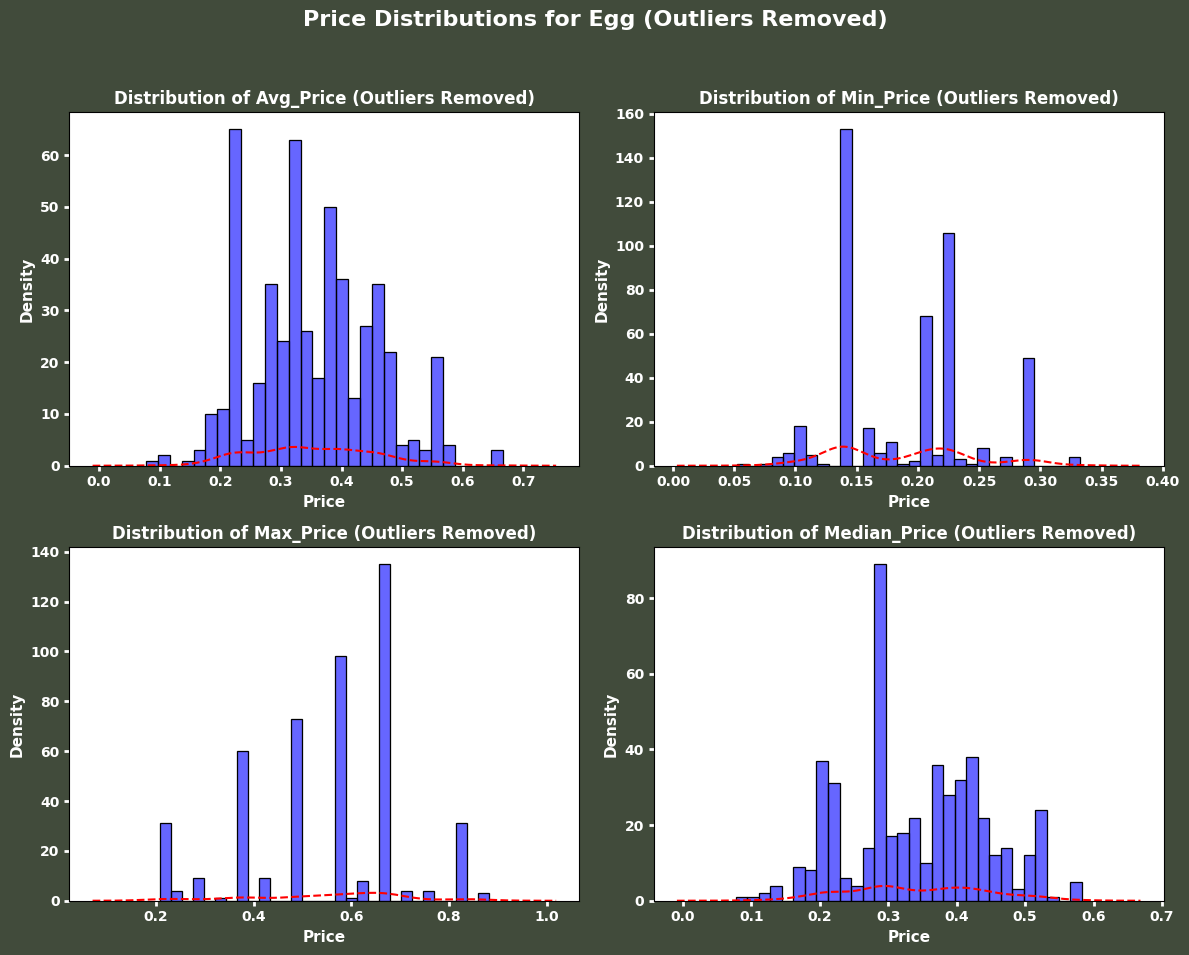

In [ ]:
# Define columns to plot
price_columns = ["Avg_Price", "Min_Price", "Max_Price", "Median_Price"]

# Unique product categories
product_categories = df["Product Category"].dropna().unique()

# Generate histograms for each product category
for category in product_categories:
    category_data = df[df["Product Category"] == category]
    
    # Set background color to match presentation style
    bg_color = "#414b3b"
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Price Distributions for {category} (Outliers Removed)", fontsize=16, color="white", fontweight="bold")

    axes = axes.flatten()  # Flatten axes array for easier iteration
    
    for i, col in enumerate(price_columns):
        # Remove outliers using IQR
        Q1 = category_data[col].quantile(0.25)
        Q3 = category_data[col].quantile(0.75)
        IQR = Q3 - Q1
        filtered_data = category_data[(category_data[col] >= (Q1 - 1.5 * IQR)) & (category_data[col] <= (Q3 + 1.5 * IQR))]

        # Plot histogram
        sns.histplot(filtered_data[col], bins=30, kde=False, color="blue", alpha=0.6, ax=axes[i])

        # Overlay density curve
        sns.kdeplot(filtered_data[col], color="red", linestyle="dashed", ax=axes[i])

        # Set title and labels with bold white text
        axes[i].set_title(f"Distribution of {col} (Outliers Removed)", color="white", fontsize=12, fontweight="bold")
        axes[i].set_xlabel("Price", color="white", fontsize=11, fontweight="bold")
        axes[i].set_ylabel("Density", color="white", fontsize=11, fontweight="bold")

        # Set ticks to bold and white
        axes[i].tick_params(axis="x", colors="white", labelsize=10, width=2)
        axes[i].tick_params(axis="y", colors="white", labelsize=10, width=2)
        
        # Make tick labels bold
        for label in axes[i].get_xticklabels():
            label.set_fontweight("bold")
        for label in axes[i].get_yticklabels():
            label.set_fontweight("bold")
        
    
    

    # Set plot background color
    fig.set_facecolor(bg_color)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Socioeconomic Correlation Analysis

This section examines **how grocery prices correlate with demographic factors**:
- **Income Levels** – Are lower-income areas paying more?
- **Education Levels** – Do better educated areas have favorable or unfavorable pricing?
- **Racial Demographics** – How do pricing patterns vary across communities?

A heatmap is used to visualize the strength and direction of correlations.


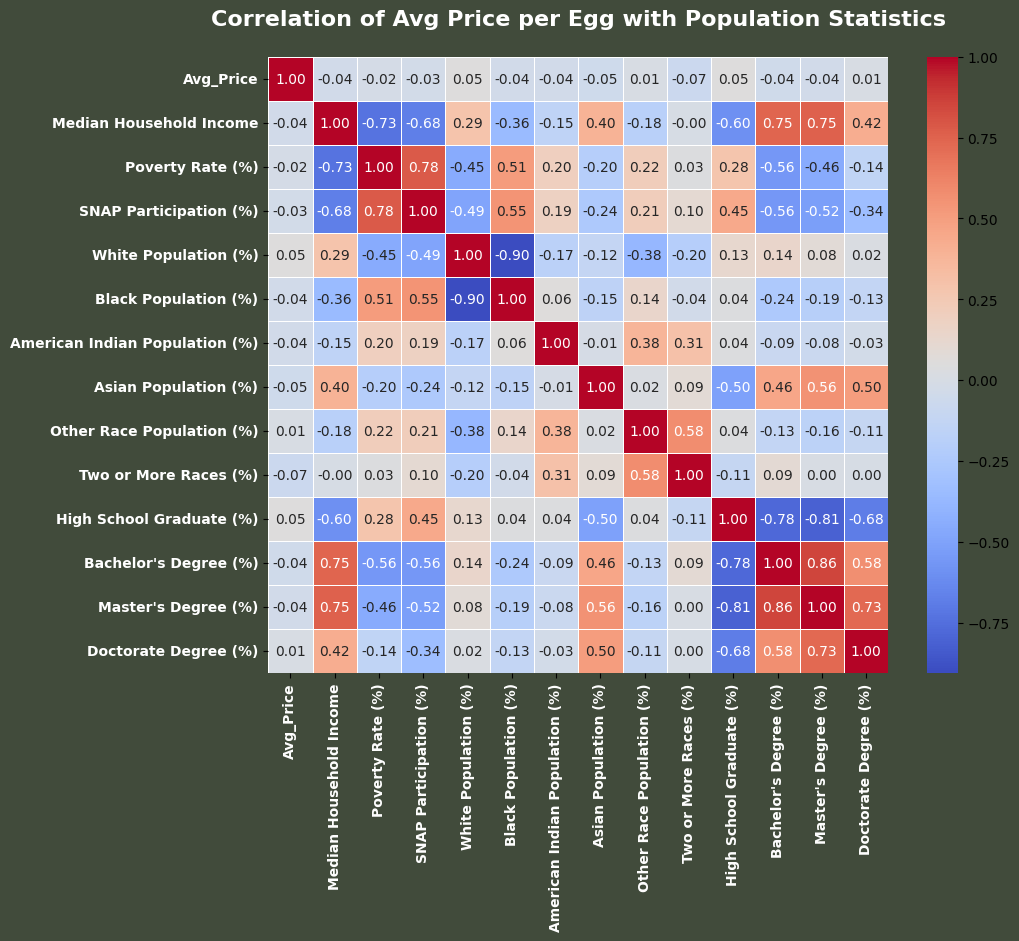

In [57]:

# Select relevant numeric columns for correlation analysis
correlation_columns = [
    "Avg_Price",
    "Median Household Income",
    "Poverty Rate (%)",
    "SNAP Participation (%)",
    "White Population (%)",
    "Black Population (%)",
    "American Indian Population (%)",
    "Asian Population (%)",
    "Other Race Population (%)",
    "Two or More Races (%)",
    "High School Graduate (%)",
    "Bachelor's Degree (%)",
    "Master's Degree (%)",
    "Doctorate Degree (%)"
]

# Filter dataset for Egg category
egg_df = df.loc[df["Product Category"].str.lower() == "egg"].copy()

# Apply IQR filtering on Avg_Price
Q1 = egg_df["Avg_Price"].quantile(0.25)
Q3 = egg_df["Avg_Price"].quantile(0.75)
IQR = Q3 - Q1

# Keep only values within the IQR range
egg_df = egg_df[(egg_df["Avg_Price"] >= (Q1 - 1.5 * IQR)) & (egg_df["Avg_Price"] <= (Q3 + 1.5 * IQR))]

# Compute correlation matrix
correlation_matrix_egg = egg_df[correlation_columns].corr()

# Set background color
bg_color = "#414b3b"

plt.figure(figsize=(10, 8), facecolor=bg_color)  # Set figure background
ax = sns.heatmap(correlation_matrix_egg, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set plot background color
ax.set_facecolor(bg_color)

# Adjust title and labels for better contrast
plt.title("Correlation of Avg Price per Egg with Population Statistics\n", fontsize=16, color="white", fontweight="bold")
plt.xticks(color="white", fontweight="bold")
plt.yticks(color="white", fontweight="bold")

plt.show()

## Correlation Summary

As shown above, there is not negative  or positive correlation to pricing  based  on racial, economic or educational  factors  based upon the available data.  It will be interesting to see if this changes over  time with the normalization of egg commodity prices,  but at present the data suggests a neutral  pricing  strategy.

## Product Keyword Trends

By analyzing **product descriptions**, we identify **common keywords** in grocery products and examine their **relationship to pricing and demographics**.

Goals:
- Find **frequent product descriptors** (e.g., `"organic"`, `"whole grain"`).
- See how **keyword popularity varies** across ZIP codes.
- Analyze **keyword correlations** with demographic statistics.

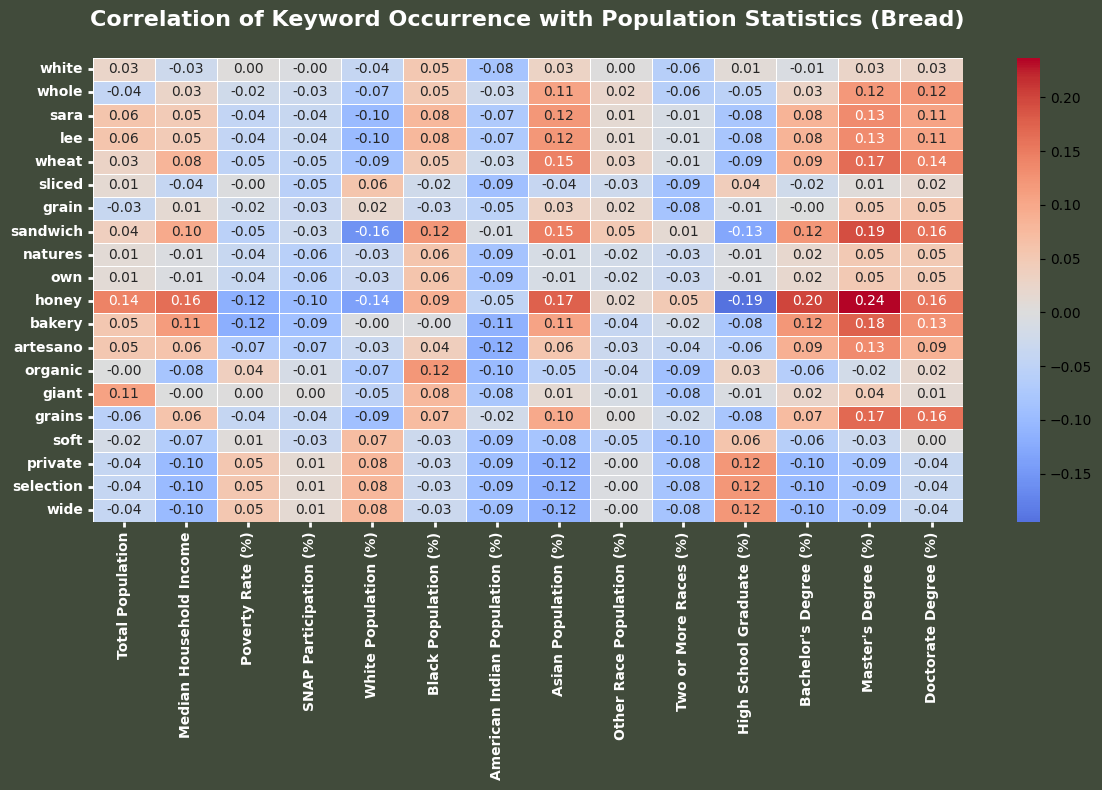

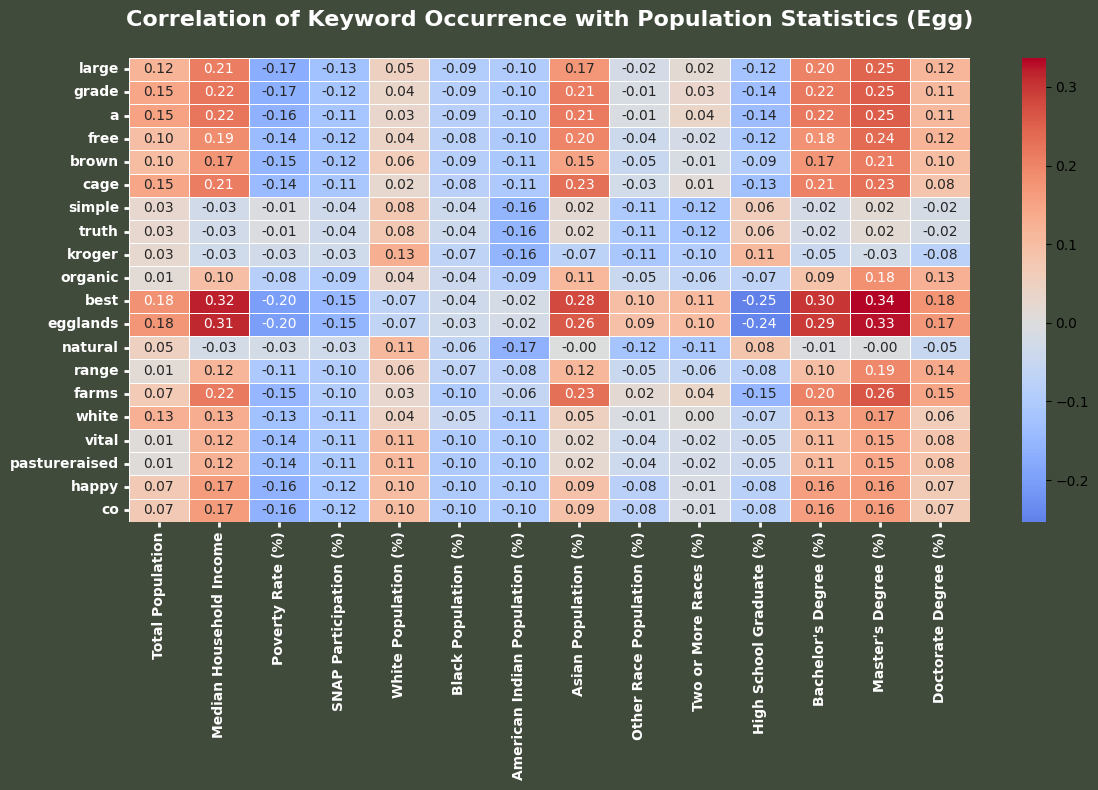

In [58]:
# Define population statistic columns for correlation
population_columns = [
    "Total Population", "Median Household Income", "Poverty Rate (%)", "SNAP Participation (%)",
    "White Population (%)", "Black Population (%)", "American Indian Population (%)",
    "Asian Population (%)", "Other Race Population (%)", "Two or More Races (%)",
    "High School Graduate (%)", "Bachelor's Degree (%)", "Master's Degree (%)", "Doctorate Degree (%)"
]

# Function to compute keyword frequency and correlations for a given product category
def compute_keyword_correlations(product_category, top_n=10):
    subset_df = df.loc[
        df["Product Category"].str.lower() == product_category.lower()
    ].copy()  # ✅ Make an explicit copy

    # Aggregate keyword occurrences
    keyword_counter = Counter()
    for keyword_dict in subset_df["ZIP_Keyword_Frequency"]:
        if isinstance(keyword_dict, dict):
            keyword_counter.update(keyword_dict)

    # Select the most common keywords for the given product category
    top_keywords = [word for word, count in keyword_counter.most_common(top_n)]

    # ✅ Use .loc to modify a copy of the dataframe
    for keyword in top_keywords:
        subset_df.loc[:, keyword] = subset_df["ZIP_Keyword_Frequency"].apply(lambda x: x.get(keyword, 0) if isinstance(x, dict) else 0)

    # Compute correlation matrix
    keyword_correlation_matrix = subset_df[top_keywords + population_columns].corr()

    # Extract correlations of keywords with population statistics
    keyword_population_corr = keyword_correlation_matrix.loc[top_keywords, population_columns]

    # Set background color
    bg_color = "#414b3b"

    # Create figure with background color
    fig, ax = plt.subplots(figsize=(12, 8), facecolor=bg_color)

    # Plot correlation heatmap
    sns.heatmap(keyword_population_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5, ax=ax)

    # Set title with bold white font
    ax.set_title(f"Correlation of Keyword Occurrence with Population Statistics ({product_category})\n",
                 fontsize=16, color="white", fontweight="bold")

    # Set tick labels to white and bold
    ax.tick_params(axis="x", colors="white", labelsize=10, width=2)
    ax.tick_params(axis="y", colors="white", labelsize=10, width=2)

    # Make tick labels bold
    for label in ax.get_xticklabels():
        label.set_fontweight("bold")
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Compute and visualize correlations for Bread
compute_keyword_correlations("Bread", top_n=20)

# Compute and visualize correlations for Egg
compute_keyword_correlations("Egg", top_n=20)


## Keyword Correlation Summary

This visualization provides the most compelling insights so far, particularly when compared to the **Avg_Price correlation matrix**. While pricing itself shows little correlation with **demographic and socioeconomic factors**, keyword trends reveal a **clear relationship between product mix and community characteristics**.

### Key Takeaways
- **Premium product keywords** (e.g., "best," "cage", "farms", "free") show strong correlations with **income, education, and racial demographics**.
    - NLP Modeling could yield more interesting results rather than simply using frequency as an indicator. 
    - Future work could focus on Brand inclusion as well as this breakdown  of  description. 
- **Higher-income, better-educated communities**—especially those with larger **White and Asian populations**—are offered a greater selection of premium products.
- This suggests that while **pricing remains relatively static**, **product availability varies dynamically across regions**, reflecting **differences in consumer demand and retailer targeting**.

These findings reinforce the strength of our dataset and highlight opportunities for **further analysis into grocery accessibility and market segmentation**.


# 📌 Conclusion & Next Steps

## Key Findings
- Grocery prices remain **relatively static** across ZIP codes.
- **Product mix varies** by socioeconomic factors, favoring wealthier, better-educated communities.
- **Correlation analysis confirms expected trends** in food access and pricing.

## Future Work
- **Refining the dataset** to include more product categories and store types.
- **State-level mapping** to provide more regionally specific insights.
- **Exploring time-series trends** to analyze price fluctuations over time.
